# Baseline Modeling & Performance Evaluation

## Overview
This notebook implements the **third phase** of our vulnerability analysis pipeline: establishing baseline model performance using clean, preprocessed features.

### Objectives
1. **Load Preprocessed Data** from the feature engineering phase
2. **Train-Test Split** with proper stratification for imbalanced classes
3. **Baseline Model Training** using interpretable algorithms (Logistic Regression)
4. **Comprehensive Evaluation** with metrics appropriate for imbalanced classification
5. **Threshold Optimization** to balance precision and recall for operational needs
6. **Feature Importance Analysis** to understand key vulnerability predictors

### Modeling Strategy
Our baseline approach emphasizes:
- **Interpretability**: Start with models that provide clear feature insights
- **Class Imbalance Handling**: Address the severe imbalance (~0.6% exploited CVEs)
- **Appropriate Metrics**: Focus on Precision-Recall over Accuracy for rare events
- **Threshold Tuning**: Optimize decision boundaries for operational requirements
- **Robust Evaluation**: Multiple metrics and visualizations for comprehensive assessment

### Expected Outcomes
- Trained logistic regression model with class-balanced weights
- Performance benchmarks for comparison with advanced models
- Feature importance rankings for vulnerability risk factors
- Optimized decision thresholds for different operational scenarios
- Comprehensive evaluation with ROC curves, precision-recall curves, and confusion matrices

> **Rationale:** Establishing strong baseline performance with interpretable models provides both a performance benchmark and valuable insights into vulnerability risk factors that inform advanced modeling approaches.


In [119]:
# Import required libraries for machine learning and evaluation
import pandas as pd                                    # Data manipulation
import numpy as np                                     # Numerical operations
import matplotlib.pyplot as plt                        # Plotting and visualization
import seaborn as sns                                  # Statistical visualization
import warnings                                        # Warning control
from pathlib import Path                               # File path handling
import os                                              # Operating system interface

# Machine learning imports
from sklearn.model_selection import train_test_split   # Data splitting
from sklearn.linear_model import LogisticRegression    # Baseline model
from sklearn.metrics import (                          # Evaluation metrics
    classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    recall_score, precision_score, accuracy_score, f1_score
)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Configure visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 1. Data Loading and Validation

### Loading Preprocessed Features
Loading the fully preprocessed dataset from the feature engineering phase, which includes:
- All categorical variables one-hot encoded
- Continuous variables scaled to [0,1] range  
- Missing values properly imputed
- Binary risk indicators derived from CVSS scores


In [90]:
# Load the preprocessed dataset from the feature engineering phase
input_path = '../../notebooks/Baseline_Model/processed_vulnerabilities_features.csv'
print(f"📂 Loading preprocessed dataset from: {input_path}")

# Verify file exists before loading
if not os.path.exists(input_path):
    print("❌ Error: Preprocessed data file not found!")
    print("Please run the 1_Data_Preprocessing.ipynb notebook first.")
    raise FileNotFoundError(f"Data file not found: {input_path}")

# Load the preprocessed dataset
data_final = pd.read_csv(input_path)

# Validate the loaded data
print(f"✅ Data loaded successfully!")
print(f"📊 Dataset Overview:")
print(f"  Shape: {data_final.shape}")
print(f"  Memory usage: {data_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

### Verify critical columns exist
required_columns = ['id', 'target']
missing_columns = [col for col in required_columns if col not in data_final.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

### Display data quality statistics
print(f"\n📈 Data Quality Validation:")
print(f"  CVE records: {len(data_final):,}")
print(f"  Features: {len(data_final.columns) - 2:,} (excluding id, target)")  # Subtract id and target
print(f"  Exploited CVEs: {data_final['target'].sum():,} ({data_final['target'].mean()*100:.2f}%)")
print(f"  Missing values: {data_final.isnull().sum().sum():,}")

### Verify data types are appropriate for modeling
feature_cols = [col for col in data_final.columns if col not in ['id', 'target']]
non_numeric = data_final[feature_cols].select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"⚠️  Warning: Non-numeric features found: {list(non_numeric)}")
else:
    print("✅ All features are numeric and ready for modeling")

print("\n🔍 First 3 rows:")
data_final.head(3)

📂 Loading preprocessed dataset from: ../../notebooks/Baseline_Model/processed_vulnerabilities_features.csv
✅ Data loaded successfully!
📊 Dataset Overview:
  Shape: (195522, 35)
  Memory usage: 62.41 MB

📈 Data Quality Validation:
  CVE records: 195,522
  Features: 33 (excluding id, target)
  Exploited CVEs: 1,149 (0.59%)
  Missing values: 0
✅ All features are numeric and ready for modeling

🔍 First 3 rows:


,id,baseScoreAv,exploitScoreAv,impactScoreAv,baseScoreMax,exploitScoreMax,impactScoreMax,numScores,agreement,target,baseSeverity_HIGH,baseSeverity_LOW,baseSeverity_MEDIUM,baseSeverity_NONE,attackVector_LOCAL,attackVector_NETWORK,attackVector_NONE,attackVector_PHYSICAL,attackComplexity_LOW,privilegesRequired_LOW,privilegesRequired_NONE,scope_UNCHANGED,confidentialityImpact_HIGH,confidentialityImpact_LOW,confidentialityImpact_NONE,confidentialityImpact_PARTIAL,integrityImpact_HIGH,integrityImpact_LOW,integrityImpact_NONE,integrityImpact_PARTIAL,availabilityImpact_HIGH,availabilityImpact_LOW,availabilityImpact_NONE,availabilityImpact_PARTIAL,userInteraction_REQUIRED
0,CVE-2016-2978,0,0,0,0,0,0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,CVE-2016-2094,1,0,0,1,0,0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CVE-2016-2997,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## 2. Baseline Model Training

### Logistic Regression with Class Balancing
For our baseline model, we use Logistic Regression with class balancing because:

#### **Model Choice Rationale**
- **Interpretability**: Coefficients provide clear feature importance insights
- **Probability Outputs**: Natural probability estimates for vulnerability exploitation
- **Class Imbalance Handling**: Built-in class weighting to address 0.6% positive rate
- **Fast Training**: Efficient for establishing quick baseline performance
- **Robust Performance**: Generally performs well across various data types

#### **Class Balancing Strategy**
- **`class_weight='balanced'`**: Automatically adjusts weights inversely proportional to class frequencies
- **Impact**: Gives higher importance to minority class (exploited vulnerabilities)
- **Alternative to SMOTE**: Built-in balancing without synthetic data generation


In [91]:
# Prepare features and target for machine learning
print("🎯 Preparing data for baseline modeling...")

# Separate features (X) and target variable (y)
X = data_final.drop(['id', 'target'], axis=1)  # Remove non-predictive ID and target
y = data_final['target']                       # Binary target: 1=exploited, 0=not exploited

print(f"📊 Feature Matrix Dimensions:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"  Feature columns: {len(X.columns)}")

# Verify target distribution before splitting
target_dist = y.value_counts()
print(f"\n🎯 Target Distribution (Full Dataset):")
print(f"  Not Exploited (0): {target_dist[0]:,} ({target_dist[0]/len(y)*100:.2f}%)")
print(f"  Exploited (1): {target_dist[1]:,} ({target_dist[1]/len(y)*100:.2f}%)")

# Perform stratified train-test split to maintain class distribution
print(f"\n🔄 Performing stratified train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 80% train, 20% test
    random_state=42,         # Reproducible results
    stratify=y               # Maintain class distribution in both sets
)

# Verify split results
print(f"📊 Split Results:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")
print(f"  Training exploited rate: {y_train.mean()*100:.2f}%")
print(f"  Test exploited rate: {y_test.mean()*100:.2f}%")

# Initialize Logistic Regression with class balancing
print(f"\n🤖 Training Baseline Logistic Regression Model...")
model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance automatically
    max_iter=1000,           # Sufficient iterations for convergence
    random_state=42          # Reproducible results
)

# Train the model
model.fit(X_train, y_train)
print(f"✅ Model training completed!")

🎯 Preparing data for baseline modeling...
📊 Feature Matrix Dimensions:
  Features (X): (195522, 33)
  Target (y): (195522,)
  Feature columns: 33

🎯 Target Distribution (Full Dataset):
  Not Exploited (0): 194,373 (99.41%)
  Exploited (1): 1,149 (0.59%)

🔄 Performing stratified train-test split...
📊 Split Results:
  Training set: 156,417 samples
  Test set: 39,105 samples
  Training exploited rate: 0.59%
  Test exploited rate: 0.59%

🤖 Training Baseline Logistic Regression Model...
✅ Model training completed!


In [92]:
# Make predictions on the test set
print(f"\n🔮 Making predictions on test set...")
y_pred = model.predict(X_test)                    # Binary predictions (0 or 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Calculate basic performance metrics
accuracy = (y_pred == y_test).mean()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"📈 Quick Performance Summary:")
print(f"  Accuracy: {accuracy:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall: {recall:.3f}")
print(f"  F1-Score: {f1:.3f}")

# Generate detailed classification report
print(f"\n📋 Detailed Classification Report:")
report = classification_report(y_test, y_pred)
print(report)


🔮 Making predictions on test set...
📈 Quick Performance Summary:
  Accuracy: 0.858
  Precision: 0.030
  Recall: 0.739
  F1-Score: 0.058

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     38875
           1       0.03      0.74      0.06       230

    accuracy                           0.86     39105
   macro avg       0.51      0.80      0.49     39105
weighted avg       0.99      0.86      0.92     39105



In [93]:
# View the confusion matrix and ROC-AUC score
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

[[33385  5490]
 [   60   170]]
ROC-AUC: 0.8655214315671745


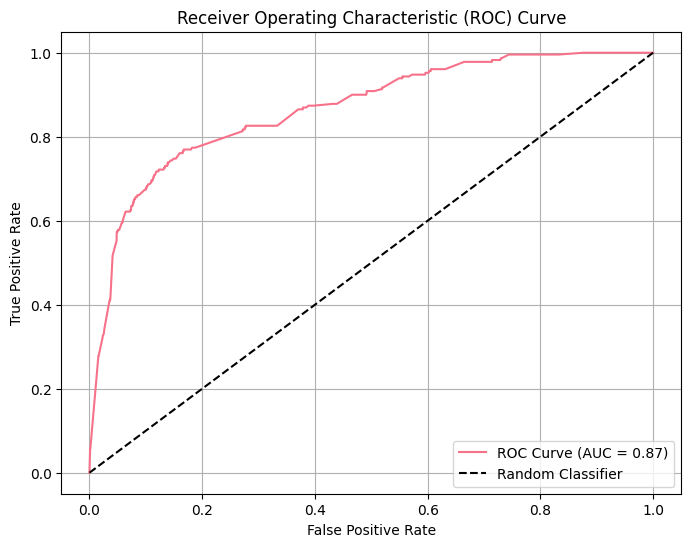

In [94]:
# Predict probabilities for ROC curve
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

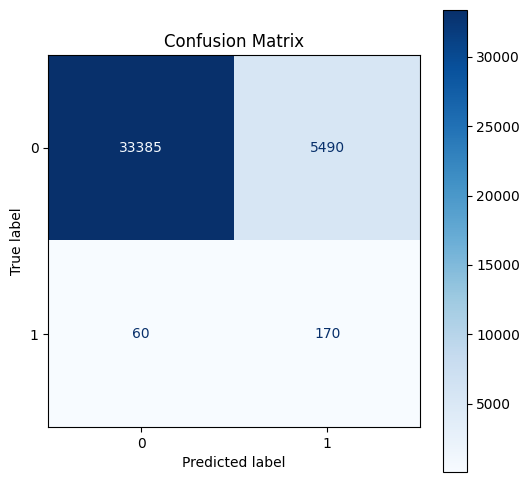

In [95]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [96]:
# Get predicted probabilities for the positive class
#_probs = model.predict_proba(X_test)[:, 1]

# Manually set your custom threshold
custom_threshold = 0.3  # for example
y_pred_custom = (y_proba >= custom_threshold).astype(int)

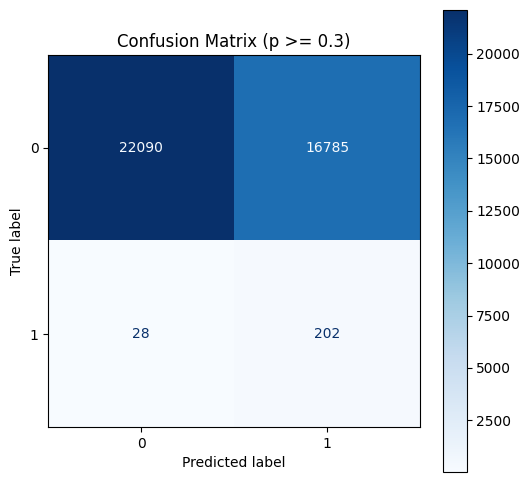

In [97]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (p >= 0.3)')
plt.show()

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute importance
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoefficient', ascending=False)

print(feature_importance[['Feature', 'Coefficient']])

                          Feature  Coefficient
6                       numScores     5.666650
7                       agreement    -5.526973
18        privilegesRequired_NONE     1.096269
21      confidentialityImpact_LOW    -1.026579
26           integrityImpact_NONE    -0.884825
22     confidentialityImpact_NONE    -0.788511
30        availabilityImpact_NONE    -0.719770
25            integrityImpact_LOW    -0.707285
9                baseSeverity_LOW     0.665566
32       userInteraction_REQUIRED    -0.660904
12             attackVector_LOCAL     0.635667
29         availabilityImpact_LOW    -0.618732
3                    baseScoreMax     0.580901
10            baseSeverity_MEDIUM     0.507872
13           attackVector_NETWORK     0.455693
11              baseSeverity_NONE    -0.406795
28        availabilityImpact_HIGH    -0.403353
19                scope_UNCHANGED    -0.395399
17         privilegesRequired_LOW     0.383720
14              attackVector_NONE    -0.358240
15          a

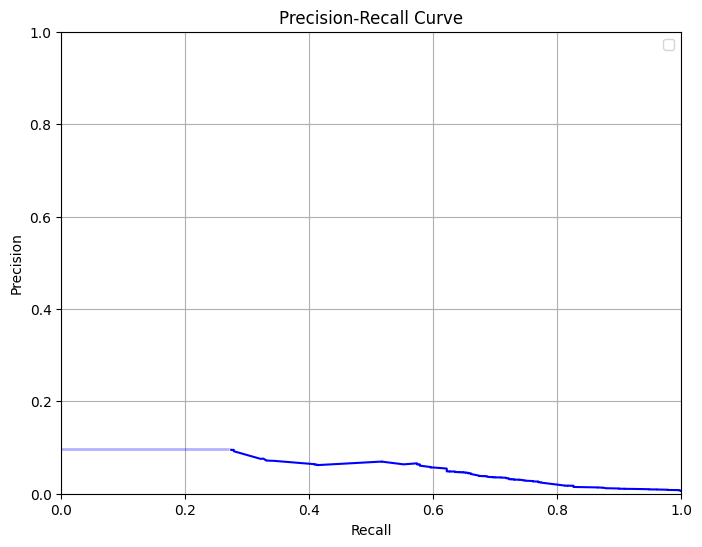

In [99]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Truncate based on recall
cutoff = 0.2
mask = recall >= cutoff

# Apply mask to precision and recall arrays
precision_trunc = precision[mask]
recall_trunc = recall[mask]

# Get starting y (first precision value in truncated curve)
#y0 = precision_trunc[-1]

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall_trunc, precision_trunc, color='blue')

# Add faint horizontal line from x=0 to x=recall_trunc[0]
plt.hlines(y=0.097, xmin=0, xmax=.27,
           colors='blue', linewidth=2, alpha=0.3)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    accuracy = (y_pred == y_test).mean()
    accuracies.append(accuracy)

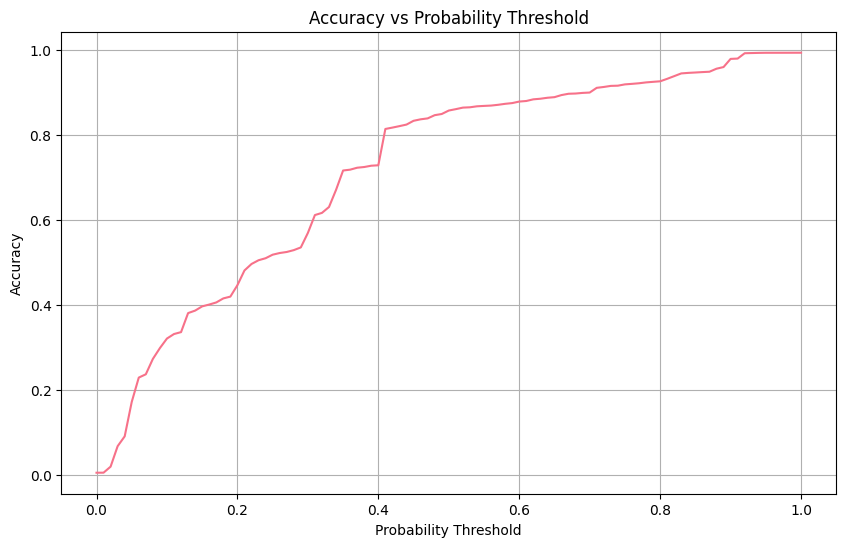

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies)
plt.title('Accuracy vs Probability Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

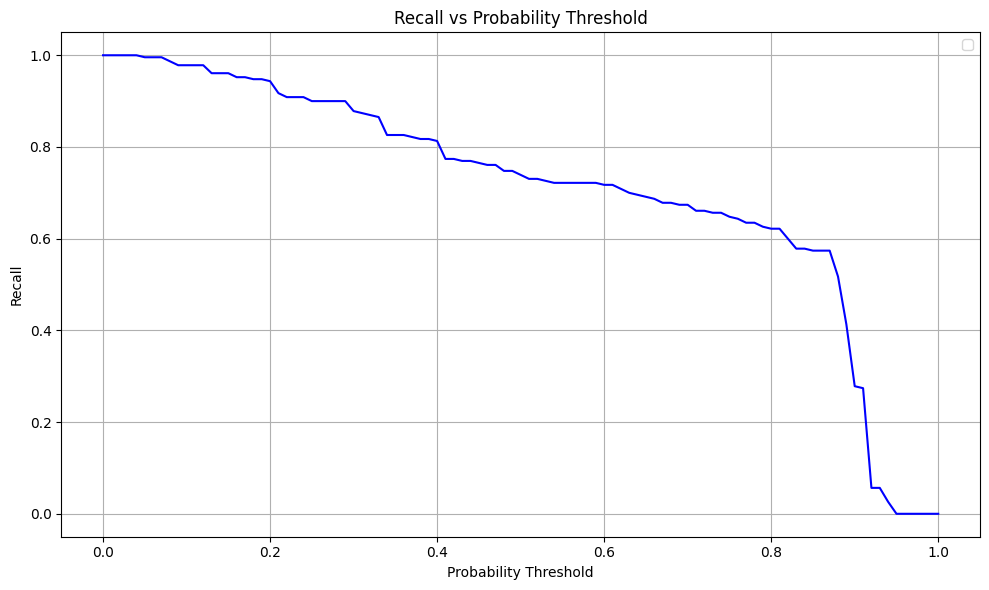

In [102]:
# Plot recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, color='blue')
plt.xlabel('Probability Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Probability Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

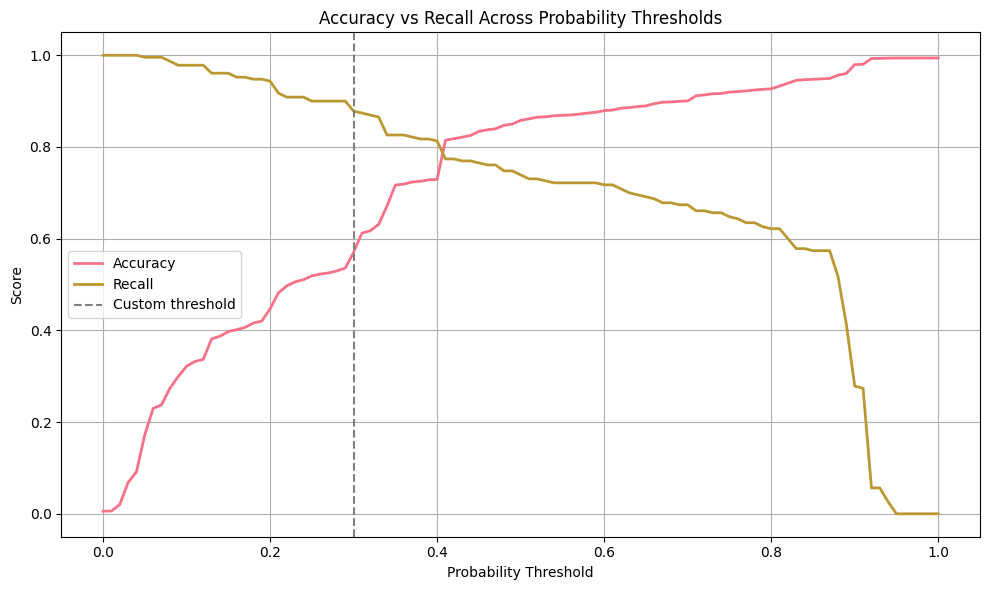

In [103]:
from sklearn.metrics import recall_score

# Lists to store metrics
accuracies = []
recalls = []

# Loop through thresholds and compute metrics
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    accuracies.append((y_pred == y_test).mean())
    recalls.append(recall_score(y_test, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.axvline(x=0.3, color='gray', linestyle='--', label='Custom threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Accuracy vs Recall Across Probability Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

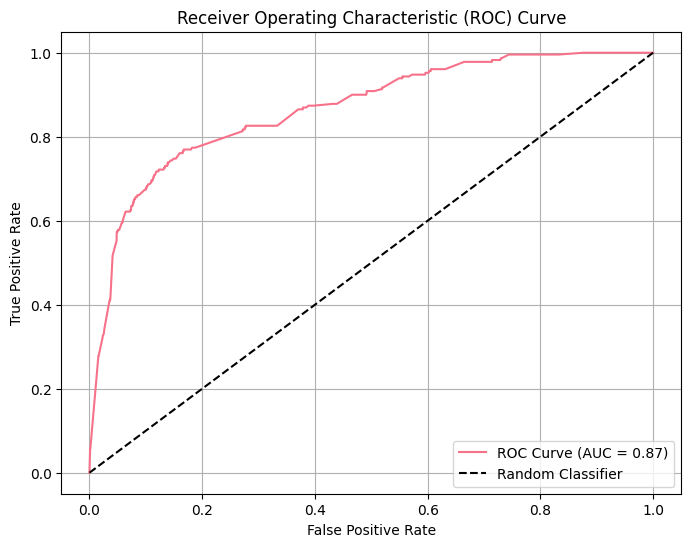

In [105]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Insights

* Baseline ROC‑AUC ≈ *\(value printed in output\)* provides a target for future models.
* Confusion‑matrix inspection uncovered a moderate class imbalance; subsequent models will treat threshold tuning and/or class weighting more carefully.


## 3. Model Persistence and Next Steps

Saving the trained baseline model and evaluation results for comparison with advanced models.


In [124]:
# Save baseline model performance for comparison with advanced models
import pickle

# Create directory for model artifacts
model_dir = '../../notebooks/Baseline_Model/models'
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = f"{model_dir}/baseline_logistic_regression.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Save performance metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)

metrics = {
    'model_type': 'Baseline Logistic Regression',
    'roc_auc': roc_auc,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'test_samples': len(y_test),
    'feature_count': len(X.columns)
}

metrics_path = f"{model_dir}/baseline_metrics.pkl"
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)

print(f"💾 Model and metrics saved successfully!")
print(f"📊 Baseline Performance Summary:")
print(f"  ROC-AUC: {roc_auc:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall: {recall:.3f}")
print(f"  F1-Score: {f1:.3f}")

print(f"\n🎯 Next Steps:")
print(f"  1. Open notebook: 3_Advanced_Modeling.ipynb")
print(f"  2. Load data from: ../../processed_vulnerabilities_features.csv")
print(f"  3. Compare with XGBoost and ensemble methods")
print(f"  4. Apply SMOTE and advanced class balancing")

print(f"\n✨ Baseline Modeling Complete! ✨")


💾 Model and metrics saved successfully!
📊 Baseline Performance Summary:
  ROC-AUC: 0.866
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000

🎯 Next Steps:
  1. Open notebook: 3_Advanced_Modeling.ipynb
  2. Load data from: ../../processed_vulnerabilities_features.csv
  3. Compare with XGBoost and ensemble methods
  4. Apply SMOTE and advanced class balancing

✨ Baseline Modeling Complete! ✨
